In [1]:
!pip install torch torchvision torchaudio

In [3]:
!pip install matplotlib

In [4]:
!pip install numpy

In [5]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights, vgg16, VGG16_Weights

import numpy as np
import copy


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

In [7]:
device

device(type='cpu')

In [8]:
imsize = 512 if torch.cuda.is_available() else 128

loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.CenterCrop(imsize),
    transforms.ToTensor(),
    ])


In [9]:
def image_loader(image_name):
    image = Image.open(image_name).convert('RGB')
    image = loader(image).unsqueeze(0)
    return image.to(device, dtype=torch.float)

In [10]:
style_img = image_loader('ice.jpg')
content_img = image_loader('cat.jpg')

assert style_img.size() == content_img.size()

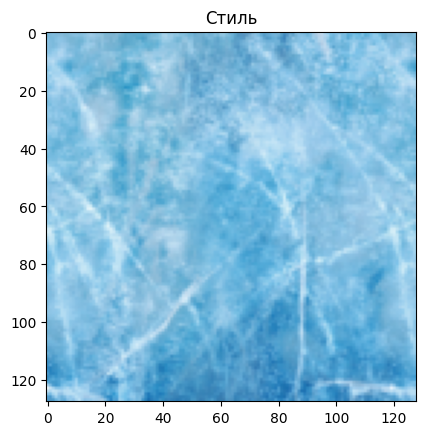

<Figure size 640x480 with 0 Axes>

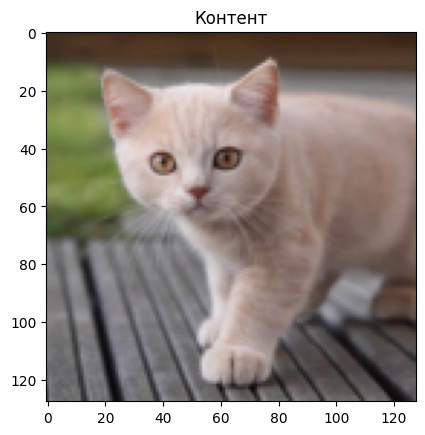

<Figure size 640x480 with 0 Axes>

In [11]:
uploader = transforms.ToPILImage()
plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = uploader(image)
    plt.imshow(image)

    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    plt.clf()

plt.figure()
imshow(style_img, title='Стиль')

plt.figure()
imshow(content_img, title='Контент')

In [12]:
class ContentLoss(nn.Module):

    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [13]:
def gram_matrix(input):
    a, b, c, d = input.size()
    features = input.view(a * b, c * d)
    G = torch.mm(features, features.t())
    return G.div(a * b * c * d)

In [14]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [15]:
# cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()
cnn = vgg16(weights=VGG16_Weights.DEFAULT).features.eval()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\pavel/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|██████████| 528M/528M [01:31<00:00, 6.07MB/s] 


In [16]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.496])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

class Normalization(nn.Module):

    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [18]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                                content_layers=content_layers_default,
                                style_layers=style_layers_default):
    normalization = Normalization(normalization_mean, normalization_std)

    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name ='relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module('content_loss_{}'.format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module('style_loss_{}'.format(i), style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]
    return model, style_losses, content_losses

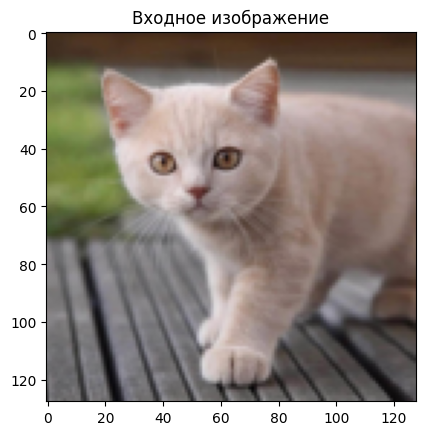

<Figure size 640x480 with 0 Axes>

In [19]:
input_img = content_img.clone()

# Чтобы использовать шум
# input_img = torch.randn(content_img.data.size())

plt.figure()
imshow(input_img, title='Входное изображение')

In [20]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [21]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=10000, content_weight=1):

    print('Построение модели переноса стиля...')
    model, style_losses, content_losses = get_style_model_and_losses(cnn, normalization_mean, normalization_std, style_img, content_img)

    input_img.requires_grad_(True)
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Оптимизируем картинку...')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            with torch.no_grad():
                input_img.clamp(0, 1)

            optimizer.zero_grad()
            model(input_img)

            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print('run {}...'.format(run))
                print('content loss: {:4f}'.format(content_score.item()))
                print('style loss: {:4f}'.format(style_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    with torch.no_grad():
        input_img.clamp(0, 1)

    return input_img

Построение модели переноса стиля...


c:\Users\pavel\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\_device.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Оптимизируем картинку...
run [50]...
content loss: 20.057817
style loss: 4224.619629

run [100]...
content loss: 22.226355
style loss: 717.730103

run [150]...
content loss: 22.778419
style loss: 172.482025

run [200]...
content loss: 22.488691
style loss: 56.671597

run [250]...
content loss: 21.671730
style loss: 27.624920

run [300]...
content loss: 20.697109
style loss: 16.774784

run [350]...
content loss: 19.778248
style loss: 11.174411

run [400]...
content loss: 18.874641
style loss: 7.640451

run [450]...
content loss: 18.131884
style loss: 5.501313

run [500]...
content loss: 17.491188
style loss: 4.226721

run [550]...
content loss: 16.982029
style loss: 3.523645

run [600]...
content loss: 16.521580
style loss: 3.064026

run [650]...
content loss: 16.152042
style loss: 2.755795

run [700]...
content loss: 15.837152
style loss: 2.547219

run [750]...
content loss: 15.579683
style loss: 2.394106

run [800]...
content loss: 15.355329
style loss: 2.269750

run [850]...
content 

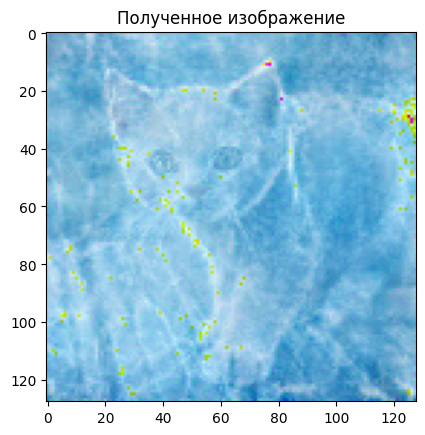

<Figure size 640x480 with 0 Axes>

In [22]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps=1000,
                            style_weight=10000000, content_weight=1)

plt.figure()
imshow(output, title='Полученное изображение')

plt.ioff()
plt.show()